cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.82e+00 | test_loss: 6.21e+00 | reg: 6.48e+00 | : 100%|█| 100/100 [00:02<00:00, 33.44


saving model version 0.1
MAE: 4.5858
MSE: 38.5933
MAPE: 4.3611
R²: 0.7075
RMSE: 6.2124
fixing (0,0,0) with log10, r2=1.0000005960464478, c=1
fixing (0,1,0) with 0, r2=0.0, c=0
fixing (0,2,0) with cos, r2=1.0000001192092896, c=2
saving model version 0.2


-2.34*log10(7.68 - 2.16*x_1) + 0.99*cos(8.71*x_3 - 3.47) + 105.74

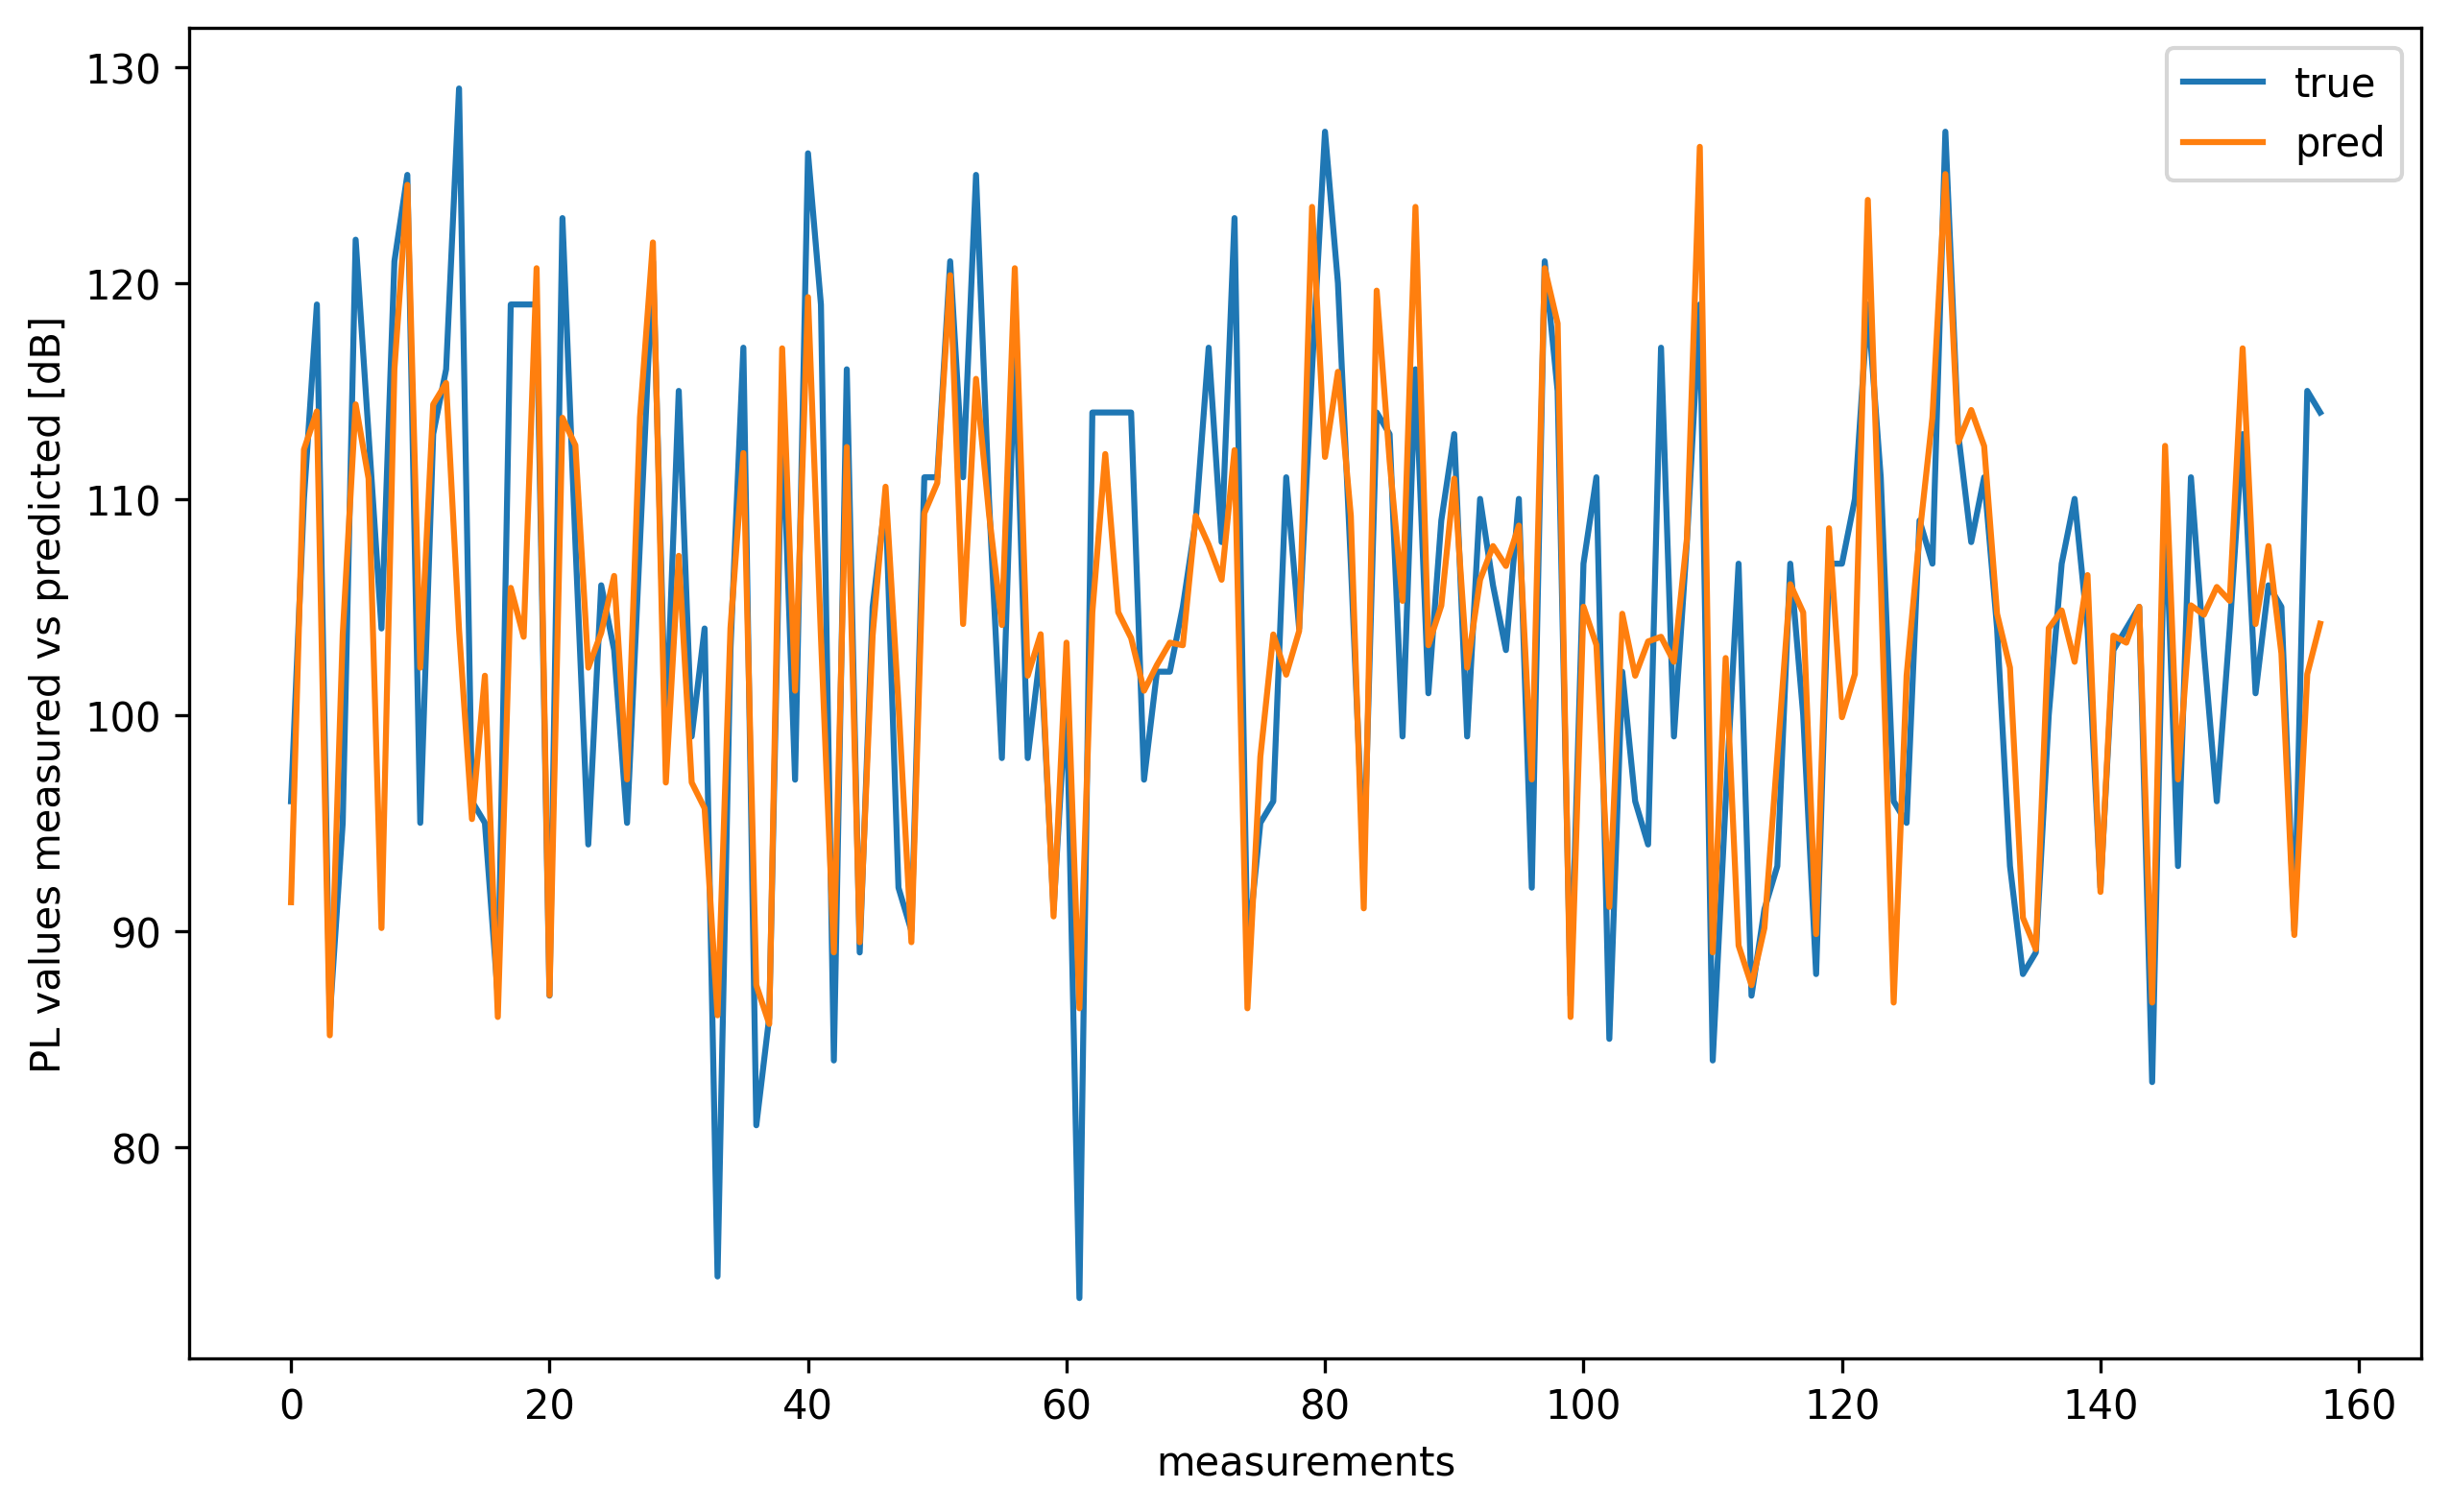

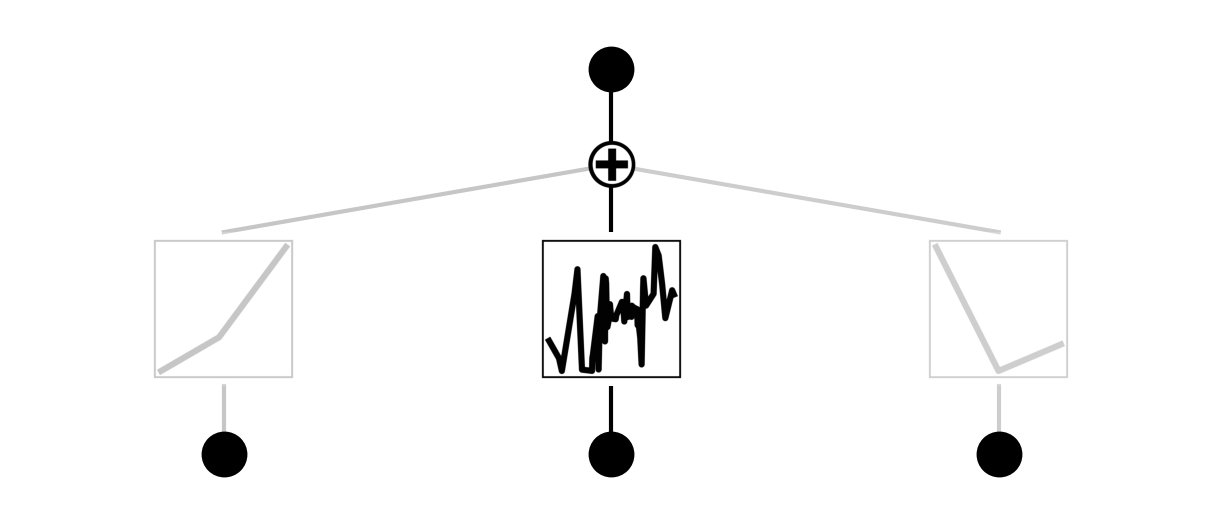

In [31]:

from kan import *
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, f, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()
    y_pred = y_pred.detach().cpu().numpy().ravel()
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    if f is not nan:
        y_symbolic = f(test_data['test_input'])
        plt.plot(time, y_symbolic)
        plt.legend(['true', 'pred', 'symbolic'])
    else:
        plt.legend(['true', 'pred'])
    plt.ylabel('PL values measured vs predicted [dB]')
    plt.xlabel('measurements')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label='metric')
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


# Read the data from the Excel file
indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Outdoor', header=0)

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = indoor_data[['hed', 'd', 'f']].values  # Input features (f and d)
labels = indoor_data['PL'].values    # Output labels 
train_input, test_input, train_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)

train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
test_label = torch.tensor(test_label, dtype=torch.float32).unsqueeze(1)

# Prepare the dataset dictionary
dataset = {}
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

model = KAN(width=[3,1], grid=50, k=3, seed=42, device=device)

# this is the learnt KAN model (splines + edge weights)
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);

eval_kan(model, nan, dataset)
model.plot()

# this is the symbolic approximation of the learnt splines with interpretable mathematical functions
add_symbolic('log10', torch.log10)
model.auto_symbolic()

#print the symbolic formula
ex_round(model.symbolic_formula()[0][0], 2)


MAE: 9.5039
MSE: 133.4273
MAPE: 9.3406
R²: -0.0112
RMSE: 11.5511


(133.42726135253906,
 np.float64(11.55107187028715),
 9.503885269165039,
 9.340572357177734,
 -0.011184215545654297)

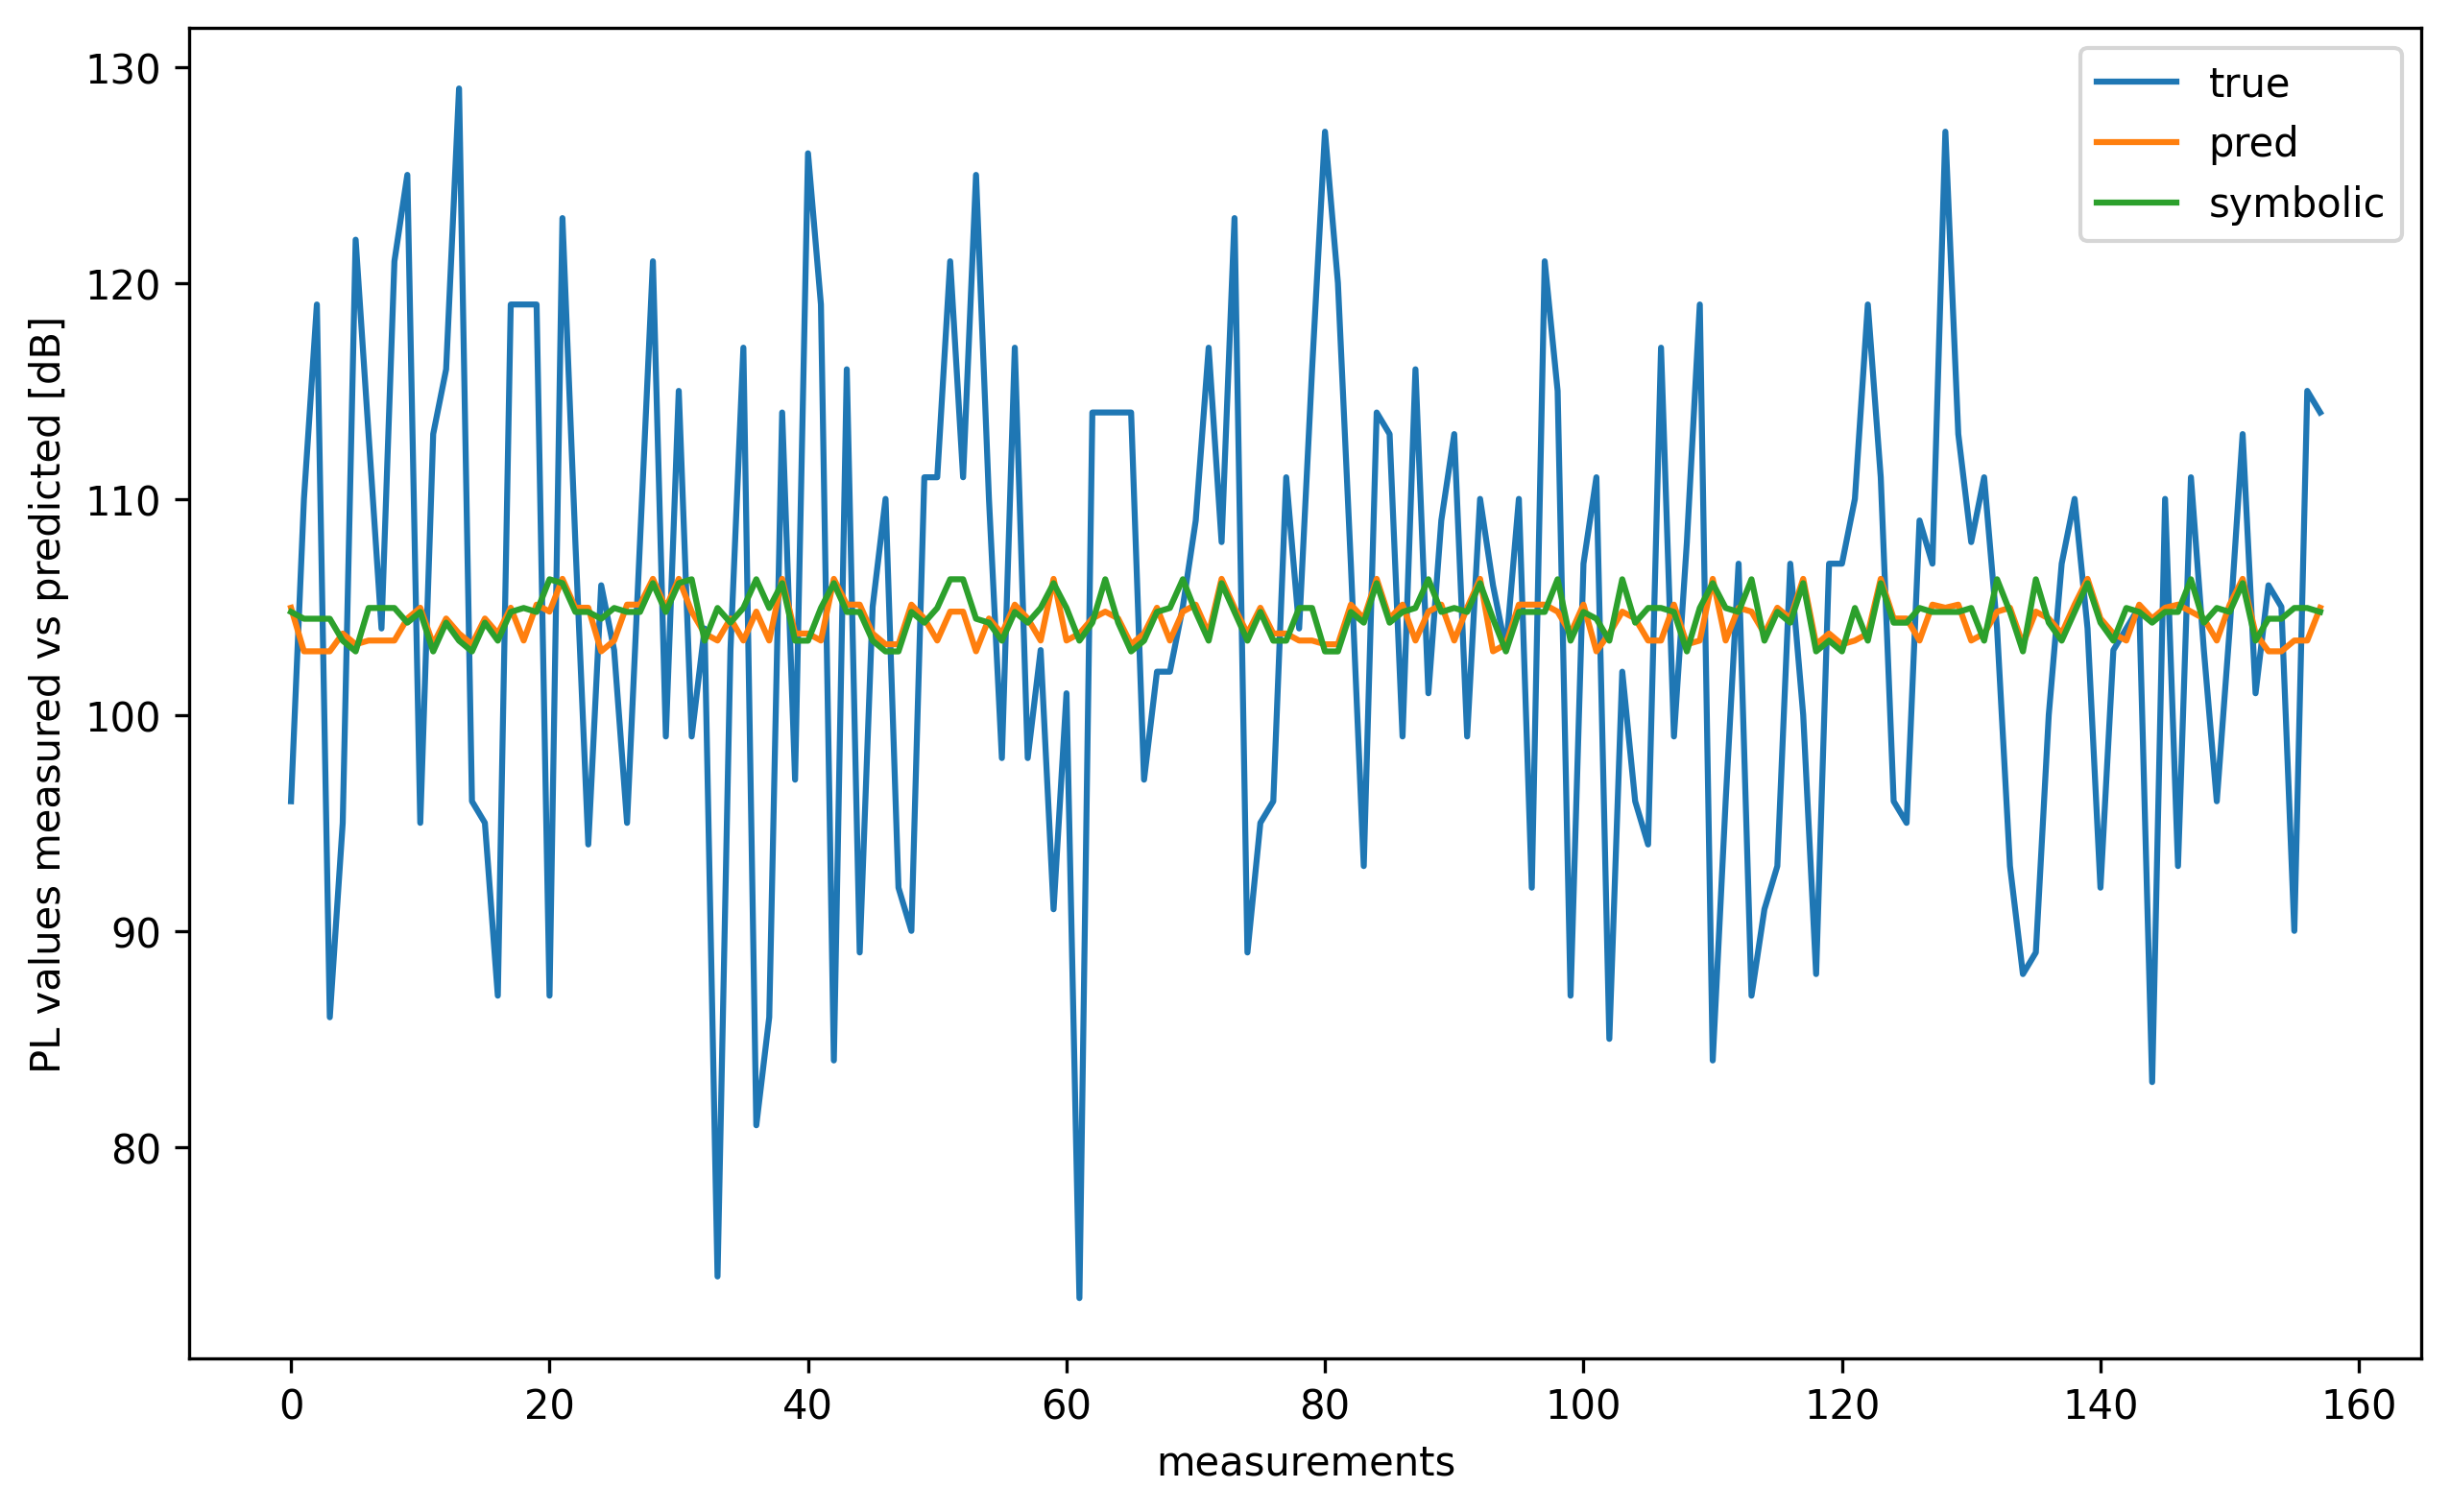

In [32]:
f = lambda x: -2.34 * torch.log10(7.68 - 2.16 * x[:, 0]) + 0.99 * torch.cos(8.71 * x[:, 2] - 3.47) + 105.74
eval_kan(model, f, dataset)

| train_loss: 1.07e+01 | test_loss: 1.15e+01 | reg: 0.00e+00 | : 100%|█| 100/100 [00:02<00:00, 36.80

saving model version 0.3
MAE: 9.4127
MSE: 133.2014
MAPE: 9.3844
R²: -0.0095
RMSE: 11.5413


-1.08*log10(3198.24*x_1 + 738.22) + 0.62*cos(8.21*x_3 - 3.43) + 109.91

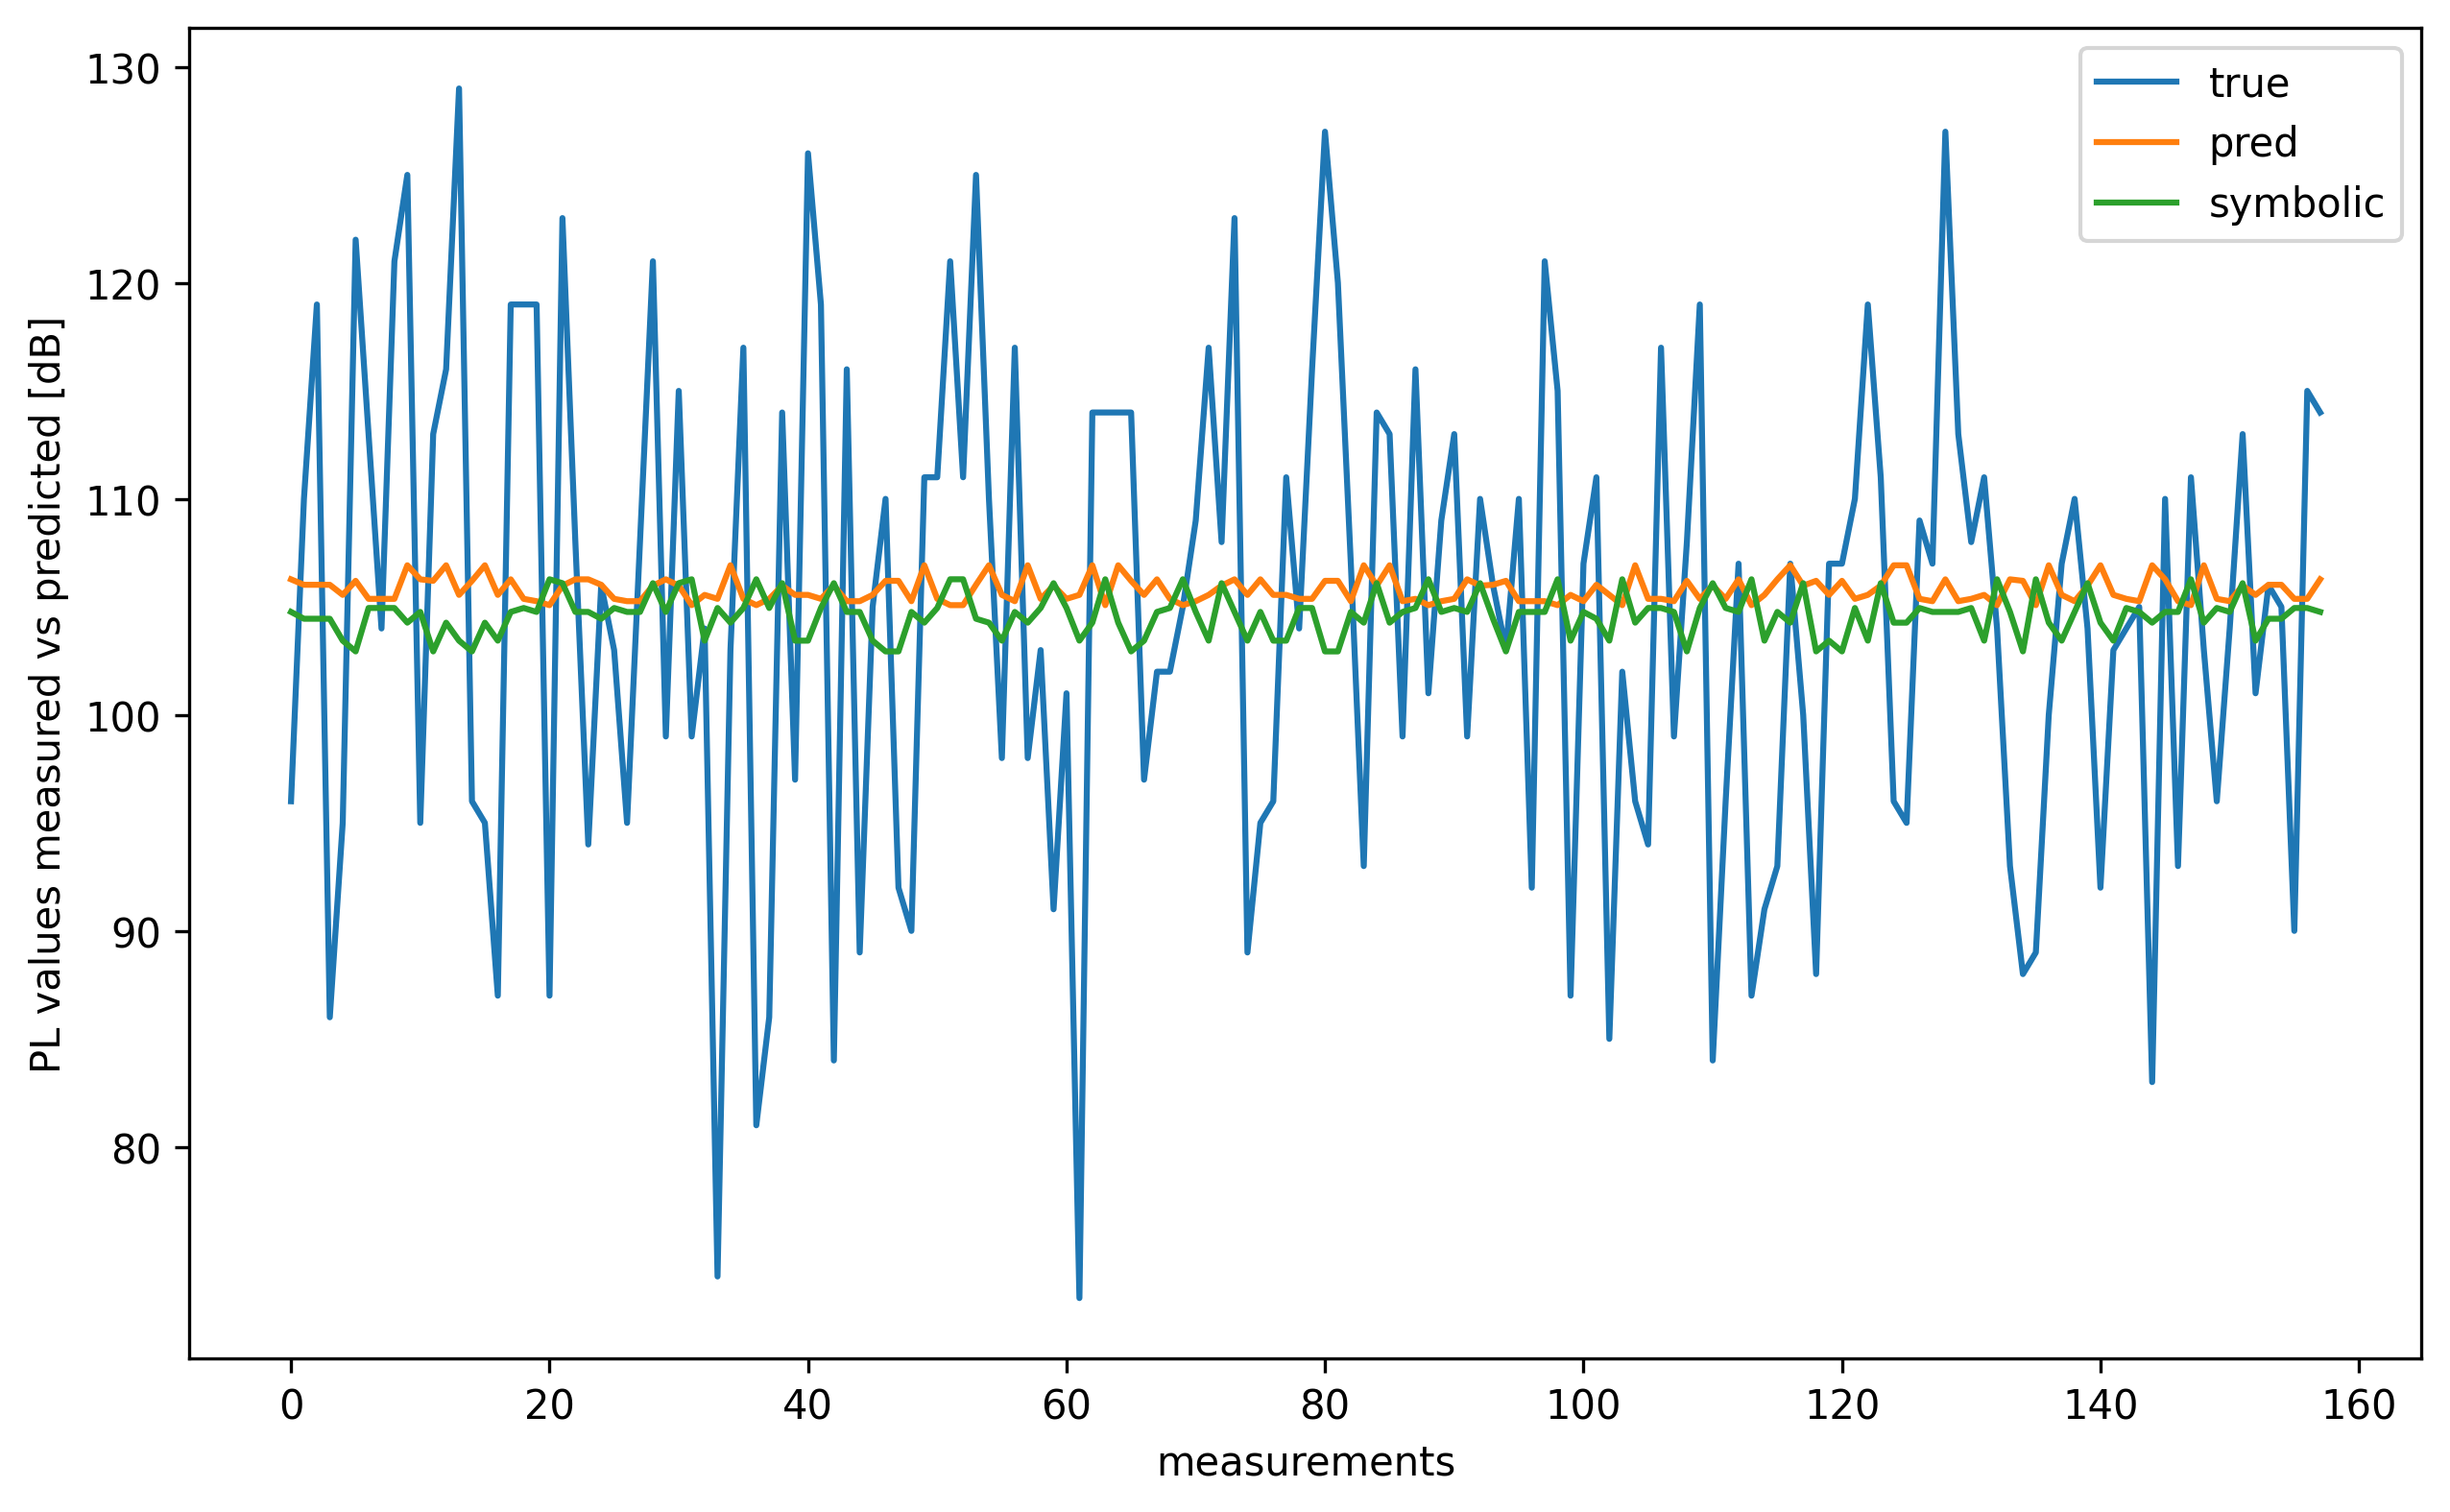

In [33]:

# we re-train the KAN architecture with the explainable symbolic approximation as the weights on thee edges 
# change compared to the model with splines 
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);
eval_kan(model, f, dataset)

#print the symbolic formula
ex_round(model.symbolic_formula()[0][0], 2)

checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.02


| train_loss: 9.39e+00 | test_loss: 1.05e+01 | reg: 4.68e+00 | : 100%|█| 50/50 [00:01<00:00, 44.12it


saving model version 0.1
MAE: 8.3635
MSE: 110.7867
MAPE: 8.2167
R²: 0.1604
RMSE: 10.5255
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.002


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.42e+00 | : 100%|█| 50/50 [00:01<00:00, 46.96it


saving model version 0.1
MAE: 8.3624
MSE: 110.9524
MAPE: 8.2133
R²: 0.1591
RMSE: 10.5334
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.0002


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.41e+00 | : 100%|█| 50/50 [00:01<00:00, 39.96it


saving model version 0.1
MAE: 8.3503
MSE: 110.7570
MAPE: 8.2014
R²: 0.1606
RMSE: 10.5241
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 2e-05


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.44e+00 | : 100%|█| 50/50 [00:01<00:00, 35.41it


saving model version 0.1
MAE: 8.3481
MSE: 110.7731
MAPE: 8.1987
R²: 0.1605
RMSE: 10.5249
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 9.39e+00 | test_loss: 1.05e+01 | reg: 4.69e+00 | : 100%|█| 100/100 [00:01<00:00, 57.79


saving model version 0.1
MAE: 8.3629
MSE: 110.8093
MAPE: 8.2146
R²: 0.1602
RMSE: 10.5266
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.42e+00 | : 100%|█| 100/100 [00:01<00:00, 58.07


saving model version 0.1
MAE: 8.3547
MSE: 110.8001
MAPE: 8.2087
R²: 0.1603
RMSE: 10.5262
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.43e+00 | : 100%|█| 100/100 [00:01<00:00, 54.59


saving model version 0.1
MAE: 8.3522
MSE: 110.7383
MAPE: 8.2062
R²: 0.1608
RMSE: 10.5232
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.41e+00 | : 100%|█| 100/100 [00:01<00:00, 50.73


saving model version 0.1
MAE: 8.3459
MSE: 110.7145
MAPE: 8.1964
R²: 0.1609
RMSE: 10.5221
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 9.39e+00 | test_loss: 1.05e+01 | reg: 4.69e+00 | : 100%|█| 200/200 [00:02<00:00, 67.20


saving model version 0.1
MAE: 8.3629
MSE: 110.8093
MAPE: 8.2146
R²: 0.1602
RMSE: 10.5266
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.43e+00 | : 100%|█| 200/200 [00:02<00:00, 76.54


saving model version 0.1
MAE: 8.3548
MSE: 110.8129
MAPE: 8.2084
R²: 0.1602
RMSE: 10.5268
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.41e+00 | : 100%|█| 200/200 [00:02<00:00, 66.78


saving model version 0.1
MAE: 8.3262
MSE: 110.5652
MAPE: 8.1790
R²: 0.1621
RMSE: 10.5150
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.44e+00 | : 100%|█| 200/200 [00:02<00:00, 67.44


saving model version 0.1
MAE: 8.3500
MSE: 110.7851
MAPE: 8.2004
R²: 0.1604
RMSE: 10.5255
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 9.39e+00 | test_loss: 1.05e+01 | reg: 4.69e+00 | : 100%|█| 300/300 [00:04<00:00, 70.74


saving model version 0.1
MAE: 8.3629
MSE: 110.8093
MAPE: 8.2146
R²: 0.1602
RMSE: 10.5266
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 9.37e+00 | test_loss: 1.05e+01 | reg: 5.37e+00 | : 100%|█| 300/300 [00:03<00:00, 76.66


saving model version 0.1
MAE: 8.3106
MSE: 110.3325
MAPE: 8.1666
R²: 0.1638
RMSE: 10.5039
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 9.37e+00 | test_loss: 1.05e+01 | reg: 5.45e+00 | : 100%|█| 300/300 [00:04<00:00, 71.34


saving model version 0.1
MAE: 8.3075
MSE: 110.3129
MAPE: 8.1639
R²: 0.1640
RMSE: 10.5030
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 9.38e+00 | test_loss: 1.05e+01 | reg: 5.43e+00 | : 100%|█| 300/300 [00:04<00:00, 74.50


saving model version 0.1
MAE: 8.3483
MSE: 110.7344
MAPE: 8.2001
R²: 0.1608
RMSE: 10.5230
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.02


| train_loss: 9.33e+00 | test_loss: 1.05e+01 | reg: 5.18e+00 | : 100%|█| 50/50 [00:01<00:00, 39.05it


saving model version 0.1
MAE: 8.4015
MSE: 110.5131
MAPE: 8.2476
R²: 0.1625
RMSE: 10.5125
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.002


| train_loss: 9.33e+00 | test_loss: 1.05e+01 | reg: 5.29e+00 | : 100%|█| 50/50 [00:01<00:00, 36.85it


saving model version 0.1
MAE: 8.4118
MSE: 110.8030
MAPE: 8.2570
R²: 0.1603
RMSE: 10.5263
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.0002


| train_loss: 9.33e+00 | test_loss: 1.05e+01 | reg: 5.23e+00 | : 100%|█| 50/50 [00:01<00:00, 40.27it


saving model version 0.1
MAE: 8.4113
MSE: 110.7124
MAPE: 8.2560
R²: 0.1610
RMSE: 10.5220
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 2e-05


| train_loss: 9.33e+00 | test_loss: 1.05e+01 | reg: 5.10e+00 | : 100%|█| 50/50 [00:01<00:00, 33.68it


saving model version 0.1
MAE: 8.4143
MSE: 110.5921
MAPE: 8.2621
R²: 0.1619
RMSE: 10.5163
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 9.33e+00 | test_loss: 1.05e+01 | reg: 5.20e+00 | : 100%|█| 100/100 [00:01<00:00, 53.18


saving model version 0.1
MAE: 8.4104
MSE: 110.6276
MAPE: 8.2595
R²: 0.1616
RMSE: 10.5180
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 9.27e+00 | test_loss: 1.05e+01 | reg: 4.93e+00 | : 100%|█| 100/100 [00:02<00:00, 41.78


saving model version 0.1
MAE: 8.3712
MSE: 109.8349
MAPE: 8.2075
R²: 0.1676
RMSE: 10.4802
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 9.32e+00 | test_loss: 1.05e+01 | reg: 5.12e+00 | : 100%|█| 100/100 [00:01<00:00, 51.44


saving model version 0.1
MAE: 8.3997
MSE: 110.6041
MAPE: 8.2417
R²: 0.1618
RMSE: 10.5168
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 9.23e+00 | test_loss: 1.04e+01 | reg: 5.23e+00 | : 100%|█| 100/100 [00:02<00:00, 39.58


saving model version 0.1
MAE: 8.3170
MSE: 108.5559
MAPE: 8.1612
R²: 0.1773
RMSE: 10.4190
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 5.26e+00 | : 100%|█| 200/200 [00:03<00:00, 56.29


saving model version 0.1
MAE: 8.3224
MSE: 108.6610
MAPE: 8.1673
R²: 0.1765
RMSE: 10.4241
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 9.23e+00 | test_loss: 1.04e+01 | reg: 5.40e+00 | : 100%|█| 200/200 [00:03<00:00, 51.06


saving model version 0.1
MAE: 8.3207
MSE: 109.0424
MAPE: 8.1686
R²: 0.1736
RMSE: 10.4423
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 5.05e+00 | : 100%|█| 200/200 [00:03<00:00, 57.52


saving model version 0.1
MAE: 8.3184
MSE: 108.4333
MAPE: 8.1629
R²: 0.1782
RMSE: 10.4131
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 9.23e+00 | test_loss: 1.04e+01 | reg: 5.24e+00 | : 100%|█| 200/200 [00:03<00:00, 55.73


saving model version 0.1
MAE: 8.3164
MSE: 108.5673
MAPE: 8.1604
R²: 0.1772
RMSE: 10.4196
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 9.23e+00 | test_loss: 1.04e+01 | reg: 5.27e+00 | : 100%|█| 300/300 [00:04<00:00, 61.82


saving model version 0.1
MAE: 8.3215
MSE: 108.5298
MAPE: 8.1692
R²: 0.1775
RMSE: 10.4178
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 9.23e+00 | test_loss: 1.04e+01 | reg: 5.44e+00 | : 100%|█| 300/300 [00:05<00:00, 59.17


saving model version 0.1
MAE: 8.3149
MSE: 109.0029
MAPE: 8.1624
R²: 0.1739
RMSE: 10.4404
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 5.06e+00 | : 100%|█| 300/300 [00:04<00:00, 67.51


saving model version 0.1
MAE: 8.3191
MSE: 108.4525
MAPE: 8.1634
R²: 0.1781
RMSE: 10.4141
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 9.23e+00 | test_loss: 1.04e+01 | reg: 5.24e+00 | : 100%|█| 300/300 [00:04<00:00, 63.39


saving model version 0.1
MAE: 8.3164
MSE: 108.5673
MAPE: 8.1604
R²: 0.1772
RMSE: 10.4196
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.02


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.55e+00 | : 100%|█| 50/50 [00:01<00:00, 48.59it


saving model version 0.1
MAE: 8.3458
MSE: 108.2185
MAPE: 8.1724
R²: 0.1799
RMSE: 10.4028
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.002


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.55e+00 | : 100%|█| 50/50 [00:00<00:00, 52.26it


saving model version 0.1
MAE: 8.3483
MSE: 108.1575
MAPE: 8.1741
R²: 0.1803
RMSE: 10.3999
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.0002


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.64e+00 | : 100%|█| 50/50 [00:00<00:00, 57.94it


saving model version 0.1
MAE: 8.3399
MSE: 108.1750
MAPE: 8.1670
R²: 0.1802
RMSE: 10.4007
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 2e-05


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.59e+00 | : 100%|█| 50/50 [00:00<00:00, 51.01it


saving model version 0.1
MAE: 8.3293
MSE: 108.0559
MAPE: 8.1565
R²: 0.1811
RMSE: 10.3950
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.02


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.65e+00 | : 100%|█| 100/100 [00:01<00:00, 62.87


saving model version 0.1
MAE: 8.3270
MSE: 107.9620
MAPE: 8.1535
R²: 0.1818
RMSE: 10.3905
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.002


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.70e+00 | : 100%|█| 100/100 [00:01<00:00, 60.41


saving model version 0.1
MAE: 8.3344
MSE: 108.0110
MAPE: 8.1598
R²: 0.1814
RMSE: 10.3928
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.0002


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.71e+00 | : 100%|█| 100/100 [00:01<00:00, 64.30


saving model version 0.1
MAE: 8.3415
MSE: 108.1406
MAPE: 8.1661
R²: 0.1805
RMSE: 10.3991
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 2e-05


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.69e+00 | : 100%|█| 100/100 [00:01<00:00, 64.27


saving model version 0.1
MAE: 8.3323
MSE: 108.1040
MAPE: 8.1586
R²: 0.1807
RMSE: 10.3973
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.02


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.67e+00 | : 100%|█| 200/200 [00:02<00:00, 74.06


saving model version 0.1
MAE: 8.3299
MSE: 107.9962
MAPE: 8.1570
R²: 0.1815
RMSE: 10.3921
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.002


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.67e+00 | : 100%|█| 200/200 [00:02<00:00, 74.02


saving model version 0.1
MAE: 8.3293
MSE: 107.9189
MAPE: 8.1552
R²: 0.1821
RMSE: 10.3884
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.0002


| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.70e+00 | : 100%|█| 200/200 [00:02<00:00, 75.21


saving model version 0.1
MAE: 8.3403
MSE: 108.1389
MAPE: 8.1653
R²: 0.1805
RMSE: 10.3990
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 2e-0

| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.68e+00 | : 100%|█| 200/200 [00:02<00:00, 77.86


saving model version 0.1
MAE: 8.3342
MSE: 108.1030
MAPE: 8.1603
R²: 0.1807
RMSE: 10.3973
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 

| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.67e+00 | : 100%|█| 300/300 [00:03<00:00, 77.90


saving model version 0.1
MAE: 8.3355
MSE: 108.0690
MAPE: 8.1616
R²: 0.1810
RMSE: 10.3956
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model versi

| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.78e+00 | : 100%|█| 300/300 [00:03<00:00, 78.09


saving model version 0.1
MAE: 8.3287
MSE: 108.1498
MAPE: 8.1570
R²: 0.1804
RMSE: 10.3995
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model

| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.76e+00 | : 100%|█| 300/300 [00:03<00:00, 79.03


saving model version 0.1
MAE: 8.3371
MSE: 108.1457
MAPE: 8.1633
R²: 0.1804
RMSE: 10.3993
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint direct

| train_loss: 9.07e+00 | test_loss: 1.04e+01 | reg: 5.69e+00 | : 100%|█| 300/300 [00:03<00:00, 85.02


saving model version 0.1
MAE: 8.3349
MSE: 108.0974
MAPE: 8.1606
R²: 0.1808
RMSE: 10.3970
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 8.07e+00 | test_loss: 9.12e+00 | reg: 5.97e+00 | : 100%|█| 50/50 [00:01<00:00, 34.52it


saving model version 0.1
MAE: 6.7663
MSE: 83.1676
MAPE: 6.6623
R²: 0.3697
RMSE: 9.1196
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.07e+00 | test_loss: 9.13e+00 | reg: 6.09e+00 | : 100%|█| 50/50 [00:01<00:00, 36.71it


saving model version 0.1
MAE: 6.7758
MSE: 83.4328
MAPE: 6.6725
R²: 0.3677
RMSE: 9.1342
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.07e+00 | test_loss: 9.13e+00 | reg: 6.22e+00 | : 100%|█| 50/50 [00:01<00:00, 34.50it


saving model version 0.1
MAE: 6.7882
MSE: 83.3279
MAPE: 6.6842
R²: 0.3685
RMSE: 9.1284
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.07e+00 | test_loss: 9.15e+00 | reg: 6.14e+00 | : 100%|█| 50/50 [00:01<00:00, 36.43it


saving model version 0.1
MAE: 6.7867
MSE: 83.7535
MAPE: 6.6845
R²: 0.3653
RMSE: 9.1517
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.07e+00 | test_loss: 9.13e+00 | reg: 5.92e+00 | : 100%|█| 100/100 [00:02<00:00, 40.43


saving model version 0.1
MAE: 6.7799
MSE: 83.4198
MAPE: 6.6770
R²: 0.3678
RMSE: 9.1334
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.06e+00 | test_loss: 9.16e+00 | reg: 6.20e+00 | : 100%|█| 100/100 [00:02<00:00, 41.38


saving model version 0.1
MAE: 6.8003
MSE: 83.8239
MAPE: 6.6977
R²: 0.3647
RMSE: 9.1555
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.07e+00 | test_loss: 9.14e+00 | reg: 6.05e+00 | : 100%|█| 100/100 [00:02<00:00, 40.06


saving model version 0.1
MAE: 6.7798
MSE: 83.5291
MAPE: 6.6770
R²: 0.3670
RMSE: 9.1394
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.06e+00 | test_loss: 9.14e+00 | reg: 6.11e+00 | : 100%|█| 100/100 [00:02<00:00, 43.64


saving model version 0.1
MAE: 6.8006
MSE: 83.5835
MAPE: 6.6999
R²: 0.3666
RMSE: 9.1424
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.06e+00 | test_loss: 9.15e+00 | reg: 6.04e+00 | : 100%|█| 200/200 [00:03<00:00, 50.93


saving model version 0.1
MAE: 6.7898
MSE: 83.6875
MAPE: 6.6873
R²: 0.3658
RMSE: 9.1481
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.02e+00 | test_loss: 9.09e+00 | reg: 5.96e+00 | : 100%|█| 200/200 [00:05<00:00, 38.57


saving model version 0.1
MAE: 6.7518
MSE: 82.6688
MAPE: 6.6509
R²: 0.3735
RMSE: 9.0922
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.06e+00 | test_loss: 9.15e+00 | reg: 6.14e+00 | : 100%|█| 200/200 [00:03<00:00, 53.21


saving model version 0.1
MAE: 6.8025
MSE: 83.6790
MAPE: 6.7007
R²: 0.3658
RMSE: 9.1476
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.02e+00 | test_loss: 9.07e+00 | reg: 5.65e+00 | : 100%|█| 200/200 [00:04<00:00, 46.43


saving model version 0.1
MAE: 6.7479
MSE: 82.3151
MAPE: 6.6465
R²: 0.3762
RMSE: 9.0728
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.06e+00 | test_loss: 9.15e+00 | reg: 6.07e+00 | : 100%|█| 300/300 [00:06<00:00, 49.51


saving model version 0.1
MAE: 6.8165
MSE: 83.7171
MAPE: 6.7147
R²: 0.3655
RMSE: 9.1497
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.01e+00 | test_loss: 9.11e+00 | reg: 6.19e+00 | : 100%|█| 300/300 [00:06<00:00, 48.39


saving model version 0.1
MAE: 6.7661
MSE: 82.9398
MAPE: 6.6670
R²: 0.3714
RMSE: 9.1071
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.01e+00 | test_loss: 9.11e+00 | reg: 6.15e+00 | : 100%|█| 300/300 [00:06<00:00, 49.86


saving model version 0.1
MAE: 6.7694
MSE: 82.9621
MAPE: 6.6698
R²: 0.3713
RMSE: 9.1084
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.02e+00 | test_loss: 9.09e+00 | reg: 5.92e+00 | : 100%|█| 300/300 [00:05<00:00, 52.95


saving model version 0.1
MAE: 6.7781
MSE: 82.6972
MAPE: 6.6761
R²: 0.3733
RMSE: 9.0938
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.77e+00 | test_loss: 8.51e+00 | reg: 6.17e+00 | : 100%|█| 50/50 [00:01<00:00, 33.14it


saving model version 0.1
MAE: 6.6063
MSE: 72.4880
MAPE: 6.4573
R²: 0.4506
RMSE: 8.5140
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.27e+00 | : 100%|█| 50/50 [00:01<00:00, 30.70it


saving model version 0.1
MAE: 6.6098
MSE: 73.0391
MAPE: 6.4630
R²: 0.4465
RMSE: 8.5463
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.57e+00 | reg: 6.49e+00 | : 100%|█| 50/50 [00:01<00:00, 33.61it


saving model version 0.1
MAE: 6.6262
MSE: 73.5233
MAPE: 6.4795
R²: 0.4428
RMSE: 8.5746
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.41e+00 | : 100%|█| 50/50 [00:01<00:00, 32.14it


saving model version 0.1
MAE: 6.6113
MSE: 73.0533
MAPE: 6.4645
R²: 0.4464
RMSE: 8.5471
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.54e+00 | reg: 6.30e+00 | : 100%|█| 100/100 [00:02<00:00, 42.95


saving model version 0.1
MAE: 6.6038
MSE: 72.9550
MAPE: 6.4560
R²: 0.4471
RMSE: 8.5414
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.54e+00 | reg: 6.35e+00 | : 100%|█| 100/100 [00:02<00:00, 43.43


saving model version 0.1
MAE: 6.6063
MSE: 72.8781
MAPE: 6.4590
R²: 0.4477
RMSE: 8.5369
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.41e+00 | : 100%|█| 100/100 [00:02<00:00, 46.90


saving model version 0.1
MAE: 6.6104
MSE: 73.0464
MAPE: 6.4631
R²: 0.4464
RMSE: 8.5467
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.45e+00 | : 100%|█| 100/100 [00:02<00:00, 45.98


saving model version 0.1
MAE: 6.6100
MSE: 73.0784
MAPE: 6.4631
R²: 0.4462
RMSE: 8.5486
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.54e+00 | reg: 6.34e+00 | : 100%|█| 200/200 [00:03<00:00, 56.14


saving model version 0.1
MAE: 6.6049
MSE: 73.0116
MAPE: 6.4572
R²: 0.4467
RMSE: 8.5447
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.54e+00 | reg: 6.35e+00 | : 100%|█| 200/200 [00:03<00:00, 58.45


saving model version 0.1
MAE: 6.6070
MSE: 72.8771
MAPE: 6.4595
R²: 0.4477
RMSE: 8.5368
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.40e+00 | : 100%|█| 200/200 [00:03<00:00, 59.61


saving model version 0.1
MAE: 6.6098
MSE: 73.0246
MAPE: 6.4622
R²: 0.4466
RMSE: 8.5454
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.44e+00 | : 100%|█| 200/200 [00:03<00:00, 62.51


saving model version 0.1
MAE: 6.6106
MSE: 73.0982
MAPE: 6.4636
R²: 0.4460
RMSE: 8.5498
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.34e+00 | : 100%|█| 300/300 [00:04<00:00, 62.00


saving model version 0.1
MAE: 6.6053
MSE: 73.0184
MAPE: 6.4580
R²: 0.4466
RMSE: 8.5451
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.54e+00 | reg: 6.41e+00 | : 100%|█| 300/300 [00:04<00:00, 64.60


saving model version 0.1
MAE: 6.6051
MSE: 73.0000
MAPE: 6.4579
R²: 0.4468
RMSE: 8.5440
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.39e+00 | : 100%|█| 300/300 [00:04<00:00, 66.53


saving model version 0.1
MAE: 6.6066
MSE: 73.0273
MAPE: 6.4596
R²: 0.4466
RMSE: 8.5456
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.76e+00 | test_loss: 8.55e+00 | reg: 6.42e+00 | : 100%|█| 300/300 [00:04<00:00, 72.61


saving model version 0.1
MAE: 6.6070
MSE: 73.0627
MAPE: 6.4600
R²: 0.4463
RMSE: 8.5477
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.86e+00 | test_loss: 7.70e+00 | reg: 4.82e+00 | : 100%|█| 50/50 [00:01<00:00, 31.39it


saving model version 0.1
MAE: 5.7673
MSE: 59.2987
MAPE: 5.5897
R²: 0.5506
RMSE: 7.7006
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.86e+00 | test_loss: 7.72e+00 | reg: 4.92e+00 | : 100%|█| 50/50 [00:01<00:00, 34.99it


saving model version 0.1
MAE: 5.7766
MSE: 59.5625
MAPE: 5.6007
R²: 0.5486
RMSE: 7.7177
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.86e+00 | test_loss: 7.67e+00 | reg: 5.03e+00 | : 100%|█| 50/50 [00:01<00:00, 31.49it


saving model version 0.1
MAE: 5.7475
MSE: 58.8770
MAPE: 5.5725
R²: 0.5538
RMSE: 7.6731
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.86e+00 | test_loss: 7.68e+00 | reg: 5.06e+00 | : 100%|█| 50/50 [00:01<00:00, 32.00it


saving model version 0.1
MAE: 5.7468
MSE: 58.9784
MAPE: 5.5702
R²: 0.5530
RMSE: 7.6797
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.82e+00 | test_loss: 7.63e+00 | reg: 4.98e+00 | : 100%|█| 100/100 [00:02<00:00, 33.39


saving model version 0.1
MAE: 5.6699
MSE: 58.2744
MAPE: 5.4939
R²: 0.5584
RMSE: 7.6338
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.82e+00 | test_loss: 7.60e+00 | reg: 4.98e+00 | : 100%|█| 100/100 [00:02<00:00, 34.92


saving model version 0.1
MAE: 5.6748
MSE: 57.8303
MAPE: 5.4898
R²: 0.5617
RMSE: 7.6046
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.85e+00 | test_loss: 7.66e+00 | reg: 5.27e+00 | : 100%|█| 100/100 [00:02<00:00, 39.76


saving model version 0.1
MAE: 5.7363
MSE: 58.6810
MAPE: 5.5613
R²: 0.5553
RMSE: 7.6603
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.85e+00 | test_loss: 7.67e+00 | reg: 5.00e+00 | : 100%|█| 100/100 [00:01<00:00, 50.56


saving model version 0.1
MAE: 5.7509
MSE: 58.7698
MAPE: 5.5722
R²: 0.5546
RMSE: 7.6661
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.81e+00 | test_loss: 7.62e+00 | reg: 5.00e+00 | : 100%|█| 200/200 [00:04<00:00, 45.40


saving model version 0.1
MAE: 5.6476
MSE: 57.9979
MAPE: 5.4747
R²: 0.5605
RMSE: 7.6156
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.81e+00 | test_loss: 7.62e+00 | reg: 5.06e+00 | : 100%|█| 200/200 [00:04<00:00, 46.77


saving model version 0.1
MAE: 5.6462
MSE: 58.0829
MAPE: 5.4720
R²: 0.5598
RMSE: 7.6212
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.81e+00 | test_loss: 7.62e+00 | reg: 5.18e+00 | : 100%|█| 200/200 [00:04<00:00, 46.20


saving model version 0.1
MAE: 5.6545
MSE: 58.0916
MAPE: 5.4805
R²: 0.5598
RMSE: 7.6218
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.81e+00 | test_loss: 7.65e+00 | reg: 5.04e+00 | : 100%|█| 200/200 [00:04<00:00, 49.64


saving model version 0.1
MAE: 5.6667
MSE: 58.5874
MAPE: 5.4928
R²: 0.5560
RMSE: 7.6542
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.81e+00 | test_loss: 7.62e+00 | reg: 5.00e+00 | : 100%|█| 300/300 [00:05<00:00, 54.72


saving model version 0.1
MAE: 5.6473
MSE: 58.0124
MAPE: 5.4745
R²: 0.5604
RMSE: 7.6166
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.81e+00 | test_loss: 7.62e+00 | reg: 5.08e+00 | : 100%|█| 300/300 [00:05<00:00, 55.16


saving model version 0.1
MAE: 5.6469
MSE: 58.1036
MAPE: 5.4725
R²: 0.5597
RMSE: 7.6226
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.81e+00 | test_loss: 7.63e+00 | reg: 5.13e+00 | : 100%|█| 300/300 [00:05<00:00, 51.42


saving model version 0.1
MAE: 5.6499
MSE: 58.1465
MAPE: 5.4761
R²: 0.5593
RMSE: 7.6254
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.81e+00 | test_loss: 7.64e+00 | reg: 5.09e+00 | : 100%|█| 300/300 [00:05<00:00, 56.08


saving model version 0.1
MAE: 5.6601
MSE: 58.3643
MAPE: 5.4838
R²: 0.5577
RMSE: 7.6397
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.51e+00 | test_loss: 7.38e+00 | reg: 5.50e+00 | : 100%|█| 50/50 [00:01<00:00, 25.90it


saving model version 0.1
MAE: 5.3530
MSE: 54.5072
MAPE: 5.1657
R²: 0.5869
RMSE: 7.3829
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.50e+00 | test_loss: 7.37e+00 | reg: 5.55e+00 | : 100%|█| 50/50 [00:01<00:00, 27.47it


saving model version 0.1
MAE: 5.3030
MSE: 54.3619
MAPE: 5.1167
R²: 0.5880
RMSE: 7.3731
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.48e+00 | test_loss: 7.31e+00 | reg: 5.63e+00 | : 100%|█| 50/50 [00:01<00:00, 26.23it


saving model version 0.1
MAE: 5.2672
MSE: 53.3760
MAPE: 5.0648
R²: 0.5955
RMSE: 7.3059
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.52e+00 | test_loss: 7.35e+00 | reg: 5.63e+00 | : 100%|█| 50/50 [00:01<00:00, 30.95it


saving model version 0.1
MAE: 5.3353
MSE: 54.0786
MAPE: 5.1402
R²: 0.5902
RMSE: 7.3538
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.46e+00 | test_loss: 7.30e+00 | reg: 5.33e+00 | : 100%|█| 100/100 [00:02<00:00, 33.62


saving model version 0.1
MAE: 5.2910
MSE: 53.3469
MAPE: 5.0958
R²: 0.5957
RMSE: 7.3039
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.46e+00 | test_loss: 7.29e+00 | reg: 5.38e+00 | : 100%|█| 100/100 [00:03<00:00, 32.82


saving model version 0.1
MAE: 5.2895
MSE: 53.1882
MAPE: 5.0980
R²: 0.5969
RMSE: 7.2930
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.46e+00 | test_loss: 7.31e+00 | reg: 5.40e+00 | : 100%|█| 100/100 [00:03<00:00, 32.25


saving model version 0.1
MAE: 5.2714
MSE: 53.3682
MAPE: 5.0793
R²: 0.5955
RMSE: 7.3054
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.47e+00 | test_loss: 7.30e+00 | reg: 5.32e+00 | : 100%|█| 100/100 [00:02<00:00, 33.67


saving model version 0.1
MAE: 5.2820
MSE: 53.3610
MAPE: 5.0835
R²: 0.5956
RMSE: 7.3049
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.45e+00 | test_loss: 7.31e+00 | reg: 5.46e+00 | : 100%|█| 200/200 [00:05<00:00, 33.90


saving model version 0.1
MAE: 5.2573
MSE: 53.3984
MAPE: 5.0721
R²: 0.5953
RMSE: 7.3074
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.45e+00 | test_loss: 7.31e+00 | reg: 5.44e+00 | : 100%|█| 200/200 [00:05<00:00, 37.27


saving model version 0.1
MAE: 5.2547
MSE: 53.3981
MAPE: 5.0695
R²: 0.5953
RMSE: 7.3074
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.45e+00 | test_loss: 7.29e+00 | reg: 5.52e+00 | : 100%|█| 200/200 [00:05<00:00, 38.81


saving model version 0.1
MAE: 5.2568
MSE: 53.2019
MAPE: 5.0671
R²: 0.5968
RMSE: 7.2940
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.46e+00 | test_loss: 7.30e+00 | reg: 5.33e+00 | : 100%|█| 200/200 [00:05<00:00, 39.16


saving model version 0.1
MAE: 5.2882
MSE: 53.3060
MAPE: 5.0973
R²: 0.5960
RMSE: 7.3011
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.45e+00 | test_loss: 7.30e+00 | reg: 5.40e+00 | : 100%|█| 300/300 [00:06<00:00, 46.55


saving model version 0.1
MAE: 5.2560
MSE: 53.3220
MAPE: 5.0698
R²: 0.5959
RMSE: 7.3022
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.44e+00 | test_loss: 7.30e+00 | reg: 5.54e+00 | : 100%|█| 300/300 [00:06<00:00, 43.43


saving model version 0.1
MAE: 5.2495
MSE: 53.3069
MAPE: 5.0611
R²: 0.5960
RMSE: 7.3012
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.45e+00 | test_loss: 7.30e+00 | reg: 5.44e+00 | : 100%|█| 300/300 [00:06<00:00, 48.52


saving model version 0.1
MAE: 5.2553
MSE: 53.2284
MAPE: 5.0666
R²: 0.5966
RMSE: 7.2958
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.45e+00 | test_loss: 7.30e+00 | reg: 5.47e+00 | : 100%|█| 300/300 [00:06<00:00, 47.68


saving model version 0.1
MAE: 5.2590
MSE: 53.2592
MAPE: 5.0726
R²: 0.5964
RMSE: 7.2979
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.84e+00 | test_loss: 6.30e+00 | reg: 6.60e+00 | : 100%|█| 50/50 [00:03<00:00, 14.84it


saving model version 0.1
MAE: 4.6396
MSE: 39.7237
MAPE: 4.4218
R²: 0.6990
RMSE: 6.3027
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.85e+00 | test_loss: 6.39e+00 | reg: 6.95e+00 | : 100%|█| 50/50 [00:02<00:00, 19.77it


saving model version 0.1
MAE: 4.7210
MSE: 40.7771
MAPE: 4.5069
R²: 0.6910
RMSE: 6.3857
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.84e+00 | test_loss: 6.27e+00 | reg: 6.79e+00 | : 100%|█| 50/50 [00:01<00:00, 25.70it


saving model version 0.1
MAE: 4.6168
MSE: 39.3400
MAPE: 4.3942
R²: 0.7019
RMSE: 6.2722
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.84e+00 | test_loss: 6.28e+00 | reg: 6.83e+00 | : 100%|█| 50/50 [00:01<00:00, 26.54it


saving model version 0.1
MAE: 4.6366
MSE: 39.3870
MAPE: 4.4213
R²: 0.7015
RMSE: 6.2759
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.82e+00 | test_loss: 6.21e+00 | reg: 6.48e+00 | : 100%|█| 100/100 [00:03<00:00, 32.15


saving model version 0.1
MAE: 4.5858
MSE: 38.5933
MAPE: 4.3611
R²: 0.7075
RMSE: 6.2124
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.82e+00 | test_loss: 6.22e+00 | reg: 6.64e+00 | : 100%|█| 100/100 [00:03<00:00, 27.11


saving model version 0.1
MAE: 4.5859
MSE: 38.7114
MAPE: 4.3597
R²: 0.7066
RMSE: 6.2218
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.82e+00 | test_loss: 6.21e+00 | reg: 6.63e+00 | : 100%|█| 100/100 [00:03<00:00, 30.80


saving model version 0.1
MAE: 4.5880
MSE: 38.5848
MAPE: 4.3646
R²: 0.7076
RMSE: 6.2117
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.82e+00 | test_loss: 6.21e+00 | reg: 6.54e+00 | : 100%|█| 100/100 [00:03<00:00, 31.99


saving model version 0.1
MAE: 4.5818
MSE: 38.5711
MAPE: 4.3577
R²: 0.7077
RMSE: 6.2106
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.81e+00 | test_loss: 6.22e+00 | reg: 6.47e+00 | : 100%|█| 200/200 [00:05<00:00, 38.46


saving model version 0.1
MAE: 4.5886
MSE: 38.6894
MAPE: 4.3647
R²: 0.7068
RMSE: 6.2201
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.82e+00 | test_loss: 6.19e+00 | reg: 6.57e+00 | : 100%|█| 200/200 [00:05<00:00, 37.73


saving model version 0.1
MAE: 4.5749
MSE: 38.3373
MAPE: 4.3471
R²: 0.7095
RMSE: 6.1917
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.80e+00 | test_loss: 6.21e+00 | reg: 6.61e+00 | : 100%|█| 200/200 [00:05<00:00, 39.64


saving model version 0.1
MAE: 4.5684
MSE: 38.5432
MAPE: 4.3451
R²: 0.7079
RMSE: 6.2083
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.81e+00 | test_loss: 6.22e+00 | reg: 6.59e+00 | : 100%|█| 200/200 [00:05<00:00, 38.68


saving model version 0.1
MAE: 4.5811
MSE: 38.7419
MAPE: 4.3565
R²: 0.7064
RMSE: 6.2243
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.80e+00 | test_loss: 6.21e+00 | reg: 6.52e+00 | : 100%|█| 300/300 [00:06<00:00, 45.71


saving model version 0.1
MAE: 4.5668
MSE: 38.5908
MAPE: 4.3435
R²: 0.7075
RMSE: 6.2122
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.81e+00 | test_loss: 6.21e+00 | reg: 6.65e+00 | : 100%|█| 300/300 [00:06<00:00, 47.38


saving model version 0.1
MAE: 4.5971
MSE: 38.5821
MAPE: 4.3777
R²: 0.7076
RMSE: 6.2114
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.80e+00 | test_loss: 6.21e+00 | reg: 6.62e+00 | : 100%|█| 300/300 [00:06<00:00, 47.36


saving model version 0.1
MAE: 4.5647
MSE: 38.5095
MAPE: 4.3425
R²: 0.7082
RMSE: 6.2056
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.81e+00 | test_loss: 6.21e+00 | reg: 6.64e+00 | : 100%|█| 300/300 [00:07<00:00, 41.27


saving model version 0.1
MAE: 4.5713
MSE: 38.5584
MAPE: 4.3477
R²: 0.7078
RMSE: 6.2095
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

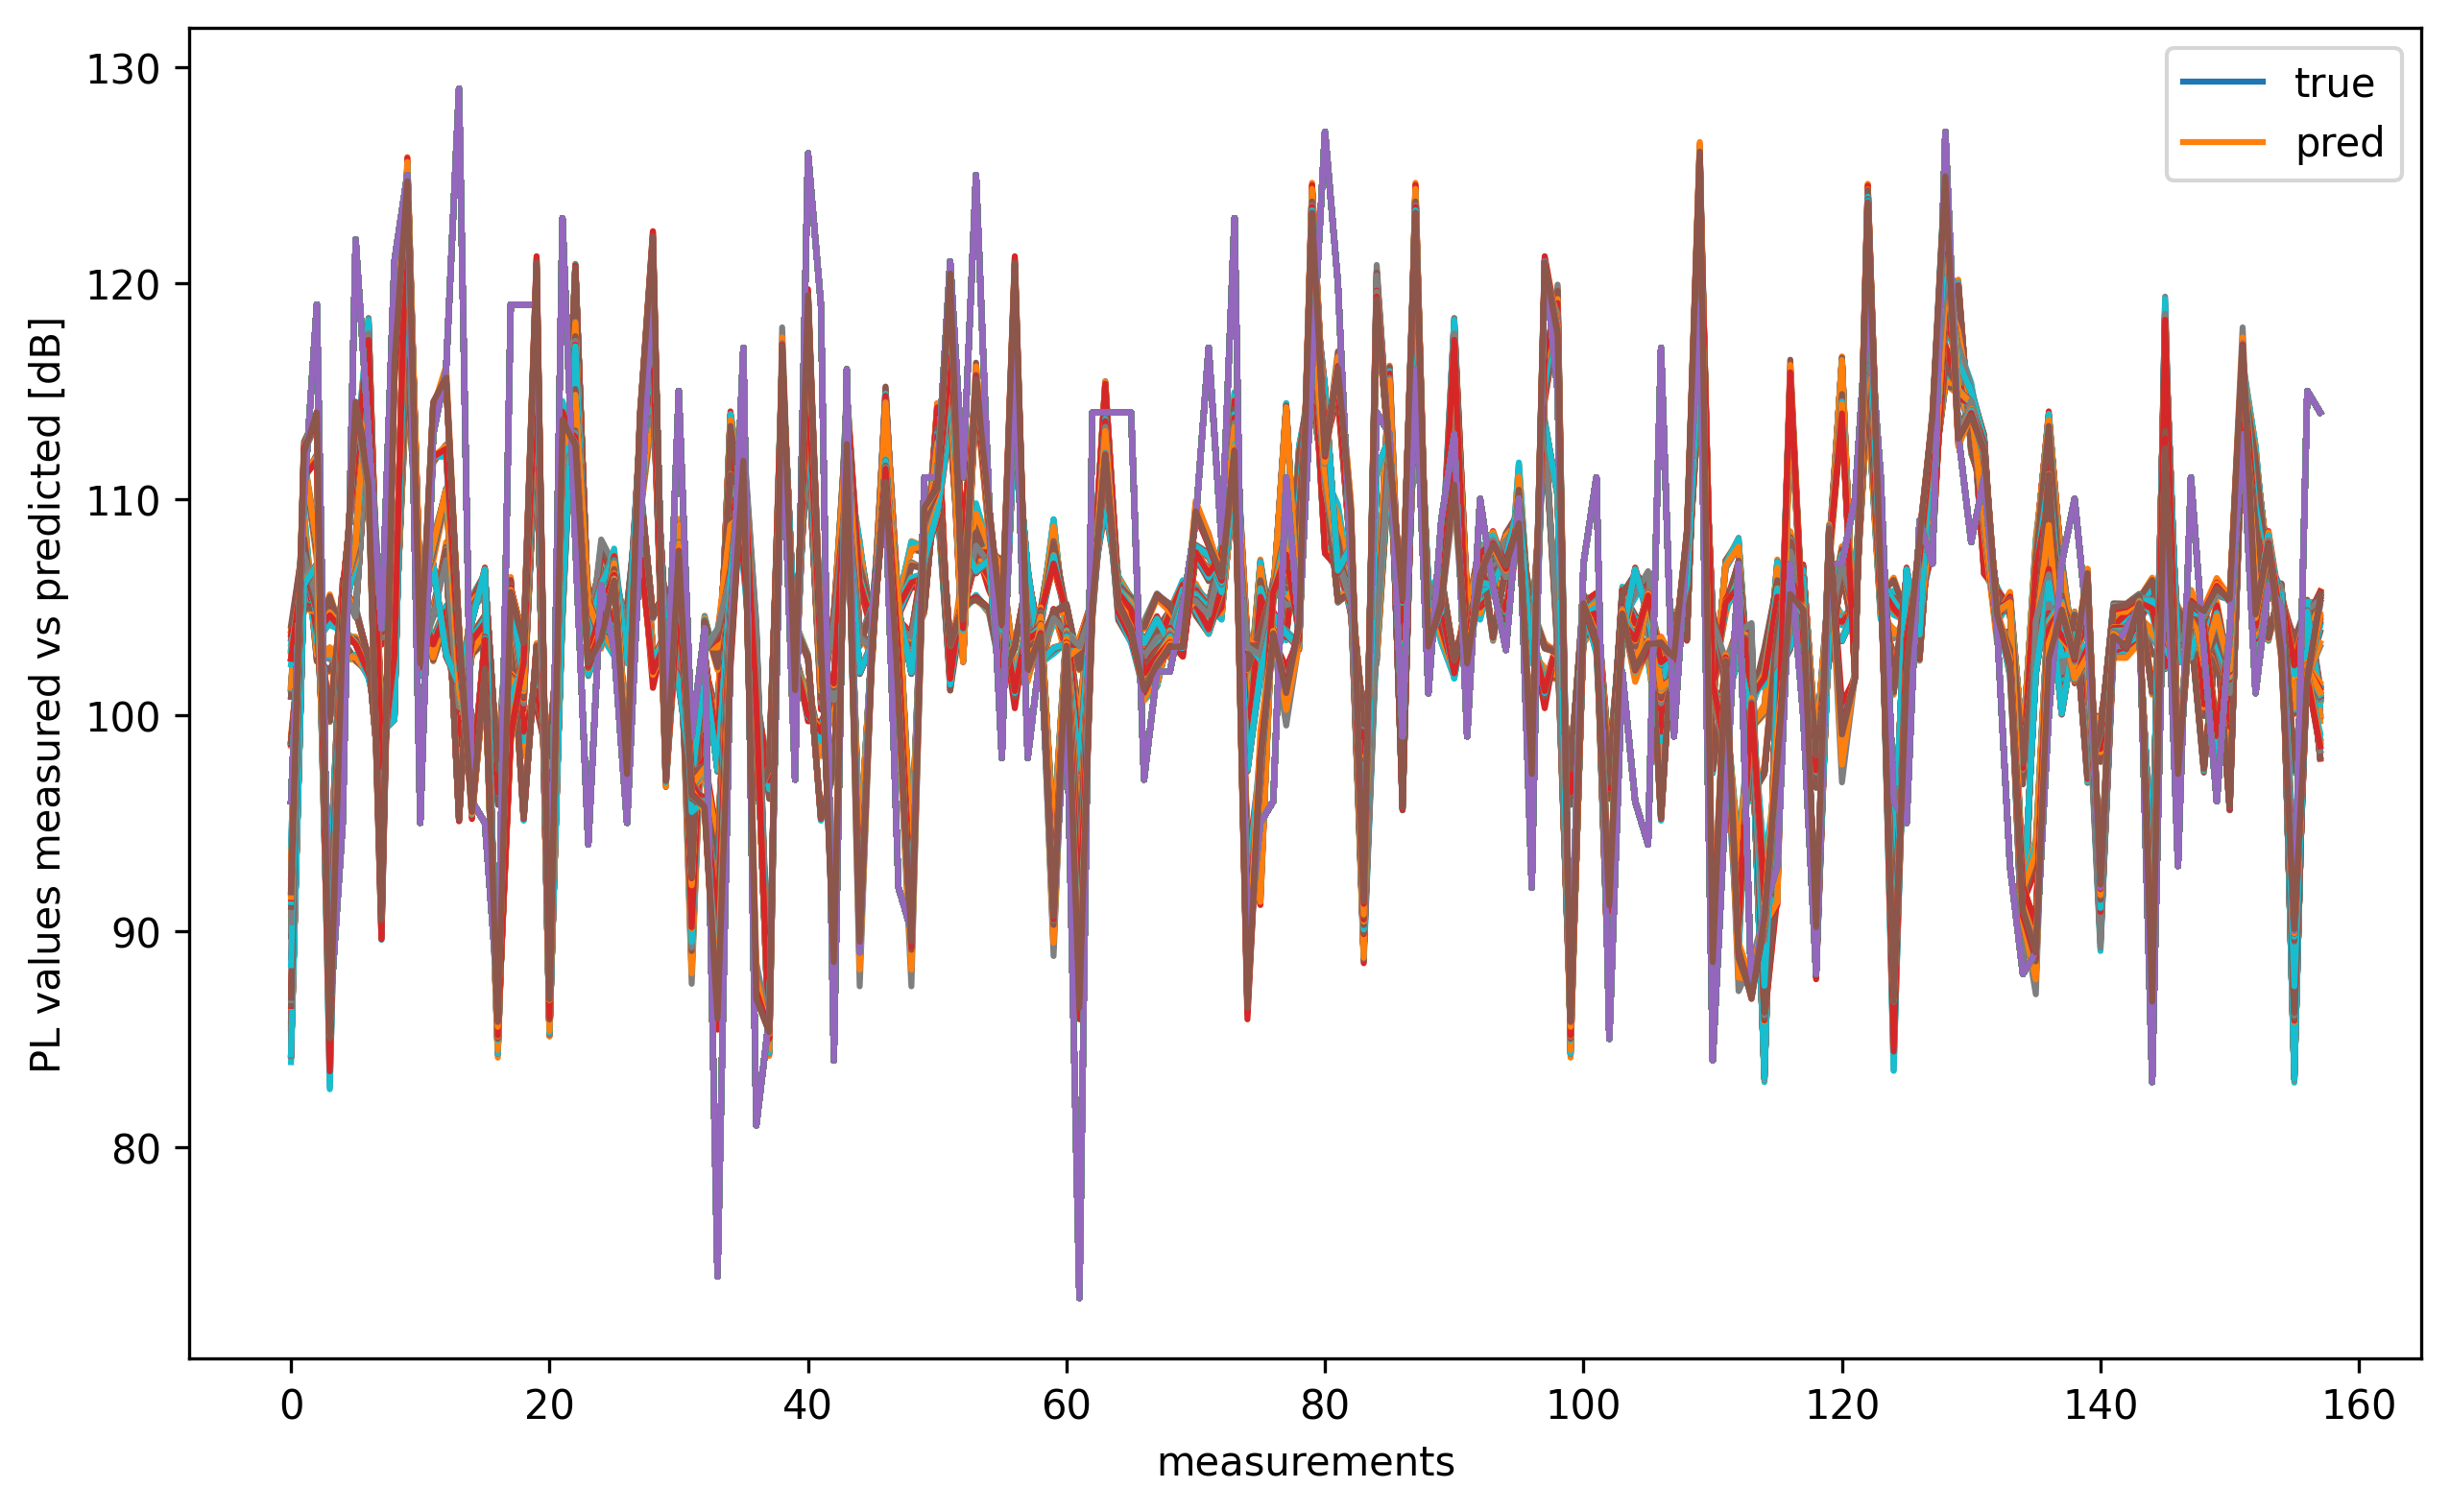

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([50, 100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[3,1], 
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            train_losses += results['train_loss']
            test_losses += results['test_loss']
            #print(np.array(train_losses).mean())

            if not np.isnan(results['train_loss']).any():
                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, nan, dataset);
                #te_mse, te_rmse, te_mae, te_mape, te_r2 = eval_kan(model, validation_data);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)
